In [ ]:
#优化器选择
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# CIFAR-10的类别
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 定义VGG网络配置
cfg = {
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
}

# 定义VGG网络类
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        self._initialize_weights()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




/home/ma-user/anaconda3/envs/PyTorch-1.8.2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda:0


In [2]:

# 数据预处理
transform_train = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为Tensor，同时将像素值从[0, 255]范围缩放到[0.0, 1.0]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载CIFAR-10数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)

# 定义实验参数
optimizers_to_test = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW
}

learning_rates = [0.01]
epoch_count = 20  # 训练轮数

results = {}


def train_model_with_optimizer(model, optimizer_name, lr, epochs=20):
    criterion = nn.CrossEntropyLoss()
    
    # 根据优化器名称创建对应优化器
    if optimizer_name == 'SGD':
        optimizer = optimizers_to_test[optimizer_name](model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    else:
        optimizer = optimizers_to_test[optimizer_name](model.parameters(), lr=lr, weight_decay=5e-4)
    
    # 不使用学习率调度器
    
    model = model.to(device)
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    times = []
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        print(f'\n第 {epoch} 轮 - {optimizer_name} (lr={lr})')
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        loop = tqdm(enumerate(trainloader), total=len(trainloader), 
                    desc=f'Training:Epoch [{epoch}/{epochs}]')
        
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loop.set_postfix(loss=loss.item(), acc=correct/total)

        # 计算训练结果
        train_epoch_loss = train_loss / len(trainloader)
        train_epoch_acc = 100. * correct / total
        train_losses.append(train_epoch_loss)
        train_accs.append(train_epoch_acc)
        
        # 测试
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(testloader), 
                                                    total=len(testloader), 
                                                    desc=f'Testing:'):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # 计算测试结果
        test_epoch_loss = test_loss / len(testloader)
        test_epoch_acc = 100. * correct / total
        test_losses.append(test_epoch_loss)
        test_accs.append(test_epoch_acc)
        
        epoch_time = time.time() - start_time
        times.append(epoch_time)
        
        print(f'测试 | 损失: {test_epoch_loss:.3f} | 准确率: {test_epoch_acc:.3f}% | 用时: {epoch_time:.1f}秒')
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'times': times,
        'final_accuracy': test_accs[-1],
        'total_time': sum(times)
    }


Files already downloaded and verified
Files already downloaded and verified


In [3]:

# 主实验循环
print("开始 VGG-13 优化器对比实验...")

# 遍历不同优化器和学习率组合
for opt_name in optimizers_to_test:
    for lr in learning_rates:
        model = VGG('VGG13')  # 创建新的VGG-13模型实例
        exp_name = f"{opt_name}_lr{lr}"
        print(f"\n开始训练 VGG-13 使用 {opt_name} 优化器，学习率 = {lr}")
        
        # 训练模型并记录结果
        results[exp_name] = train_model_with_optimizer(model, opt_name, lr, epochs=epoch_count)
        
        # 保存模型
        torch.save(model.state_dict(), f'cifar10_vgg13_{opt_name.lower()}_lr{lr}.pth')
        print(f"模型已保存为 cifar10_vgg13_{opt_name.lower()}_lr{lr}.pth")


开始 VGG-13 优化器对比实验...

开始训练 VGG-13 使用 SGD 优化器，学习率 = 0.01

第 1 轮 - SGD (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.38it/s]

测试 | 损失: 2.299 | 准确率: 10.860% | 用时: 24.1秒

第 2 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.92it/s]

测试 | 损失: 2.031 | 准确率: 18.930% | 用时: 24.0秒

第 3 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.65it/s]

测试 | 损失: 1.841 | 准确率: 22.100% | 用时: 24.2秒

第 4 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.83it/s]


测试 | 损失: 1.732 | 准确率: 28.590% | 用时: 24.2秒

第 5 轮 - SGD (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.92it/s]


测试 | 损失: 1.565 | 准确率: 36.820% | 用时: 24.2秒

第 6 轮 - SGD (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.96it/s]

测试 | 损失: 1.373 | 准确率: 46.960% | 用时: 24.3秒

第 7 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.39it/s]

测试 | 损失: 1.328 | 准确率: 50.810% | 用时: 24.1秒

第 8 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.44it/s]

测试 | 损失: 1.366 | 准确率: 54.340% | 用时: 24.3秒

第 9 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.53it/s]

测试 | 损失: 1.175 | 准确率: 58.940% | 用时: 24.2秒

第 10 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.28it/s]

测试 | 损失: 1.095 | 准确率: 62.320% | 用时: 24.3秒

第 11 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.83it/s]

测试 | 损失: 1.149 | 准确率: 64.950% | 用时: 24.0秒

第 12 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.26it/s]

测试 | 损失: 1.007 | 准确率: 67.280% | 用时: 24.2秒

第 13 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.66it/s]

测试 | 损失: 1.100 | 准确率: 67.590% | 用时: 24.2秒

第 14 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.39it/s]

测试 | 损失: 1.240 | 准确率: 65.040% | 用时: 24.2秒

第 15 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.88it/s]


测试 | 损失: 1.273 | 准确率: 68.110% | 用时: 24.3秒

第 16 轮 - SGD (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.34it/s]

测试 | 损失: 1.238 | 准确率: 67.240% | 用时: 24.2秒

第 17 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.88it/s]

测试 | 损失: 1.003 | 准确率: 73.740% | 用时: 24.5秒

第 18 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.48it/s]

测试 | 损失: 1.141 | 准确率: 71.830% | 用时: 24.3秒

第 19 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.82it/s]

测试 | 损失: 1.132 | 准确率: 71.400% | 用时: 24.5秒

第 20 轮 - SGD (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.09it/s]


测试 | 损失: 1.213 | 准确率: 73.330% | 用时: 24.3秒
模型已保存为 cifar10_vgg13_sgd_lr0.01.pth

开始训练 VGG-13 使用 Adam 优化器，学习率 = 0.01

第 1 轮 - Adam (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.39it/s]

测试 | 损失: 2.261 | 准确率: 11.080% | 用时: 24.5秒

第 2 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.59it/s]

测试 | 损失: 2.082 | 准确率: 15.560% | 用时: 24.3秒

第 3 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.73it/s]

测试 | 损失: 2.081 | 准确率: 24.780% | 用时: 24.0秒

第 4 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.88it/s]

测试 | 损失: 1.980 | 准确率: 21.140% | 用时: 23.5秒

第 5 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.31it/s]

测试 | 损失: 1.856 | 准确率: 25.410% | 用时: 23.4秒

第 6 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.89it/s]


测试 | 损失: 1.942 | 准确率: 27.030% | 用时: 23.3秒

第 7 轮 - Adam (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.79it/s]

测试 | 损失: 1.795 | 准确率: 30.750% | 用时: 23.4秒

第 8 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 55.28it/s]

测试 | 损失: 1.679 | 准确率: 34.380% | 用时: 23.3秒

第 9 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.87it/s]

测试 | 损失: 1.460 | 准确率: 43.770% | 用时: 23.3秒

第 10 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 55.63it/s]

测试 | 损失: 1.459 | 准确率: 43.700% | 用时: 23.2秒

第 11 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 55.21it/s]

测试 | 损失: 1.364 | 准确率: 50.190% | 用时: 23.3秒

第 12 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.88it/s]


测试 | 损失: 1.253 | 准确率: 54.710% | 用时: 23.3秒

第 13 轮 - Adam (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.75it/s]

测试 | 损失: 1.779 | 准确率: 40.740% | 用时: 23.3秒

第 14 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.33it/s]

测试 | 损失: 3.078 | 准确率: 27.110% | 用时: 23.4秒

第 15 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 55.38it/s]

测试 | 损失: 1.255 | 准确率: 54.390% | 用时: 23.1秒

第 16 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.05it/s]

测试 | 损失: 1.361 | 准确率: 52.370% | 用时: 23.2秒

第 17 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.66it/s]

测试 | 损失: 1.554 | 准确率: 47.410% | 用时: 23.2秒

第 18 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 56.04it/s]

测试 | 损失: 1.124 | 准确率: 60.210% | 用时: 23.2秒

第 19 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 55.48it/s]

测试 | 损失: 1.468 | 准确率: 52.800% | 用时: 23.2秒

第 20 轮 - Adam (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.51it/s]


测试 | 损失: 1.063 | 准确率: 62.530% | 用时: 23.1秒
模型已保存为 cifar10_vgg13_adam_lr0.01.pth

开始训练 VGG-13 使用 RMSprop 优化器，学习率 = 0.01

第 1 轮 - RMSprop (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.06it/s]

测试 | 损失: 2.303 | 准确率: 10.000% | 用时: 24.3秒

第 2 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.96it/s]


测试 | 损失: 2.303 | 准确率: 10.000% | 用时: 24.3秒

第 3 轮 - RMSprop (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.01it/s]

测试 | 损失: 2.303 | 准确率: 10.000% | 用时: 24.2秒

第 4 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.25it/s]

测试 | 损失: 2.303 | 准确率: 10.000% | 用时: 24.5秒

第 5 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.38it/s]

测试 | 损失: 2.303 | 准确率: 10.000% | 用时: 24.2秒

第 6 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.86it/s]

测试 | 损失: 2.303 | 准确率: 10.000% | 用时: 24.3秒

第 7 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.62it/s]

测试 | 损失: 2.303 | 准确率: 10.000% | 用时: 24.6秒

第 8 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.18it/s]

测试 | 损失: 2.303 | 准确率: 10.000% | 用时: 24.2秒

第 9 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.66it/s]

测试 | 损失: 2.315 | 准确率: 8.660% | 用时: 24.2秒

第 10 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.84it/s]

测试 | 损失: 2.115 | 准确率: 17.980% | 用时: 23.8秒

第 11 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.86it/s]

测试 | 损失: 1.955 | 准确率: 20.320% | 用时: 23.6秒

第 12 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.79it/s]

测试 | 损失: 2.490 | 准确率: 12.810% | 用时: 23.4秒

第 13 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.75it/s]

测试 | 损失: 3.458 | 准确率: 10.170% | 用时: 23.4秒

第 14 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.58it/s]

测试 | 损失: 2.482 | 准确率: 18.290% | 用时: 23.3秒

第 15 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.38it/s]

测试 | 损失: 2.424 | 准确率: 19.430% | 用时: 23.2秒

第 16 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.45it/s]

测试 | 损失: 19.159 | 准确率: 10.010% | 用时: 23.2秒

第 17 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.47it/s]

测试 | 损失: 8.497 | 准确率: 10.000% | 用时: 23.3秒

第 18 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.91it/s]

测试 | 损失: 2.061 | 准确率: 17.380% | 用时: 23.1秒

第 19 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.92it/s]

测试 | 损失: 1.814 | 准确率: 26.380% | 用时: 23.2秒

第 20 轮 - RMSprop (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.94it/s]


测试 | 损失: 1.948 | 准确率: 27.240% | 用时: 23.3秒
模型已保存为 cifar10_vgg13_rmsprop_lr0.01.pth

开始训练 VGG-13 使用 AdamW 优化器，学习率 = 0.01

第 1 轮 - AdamW (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.79it/s]

测试 | 损失: 1.977 | 准确率: 19.420% | 用时: 24.4秒

第 2 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.36it/s]

测试 | 损失: 1.860 | 准确率: 22.880% | 用时: 24.3秒

第 3 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.81it/s]

测试 | 损失: 1.679 | 准确率: 29.880% | 用时: 24.4秒

第 4 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.05it/s]

测试 | 损失: 1.644 | 准确率: 34.290% | 用时: 24.6秒

第 5 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.64it/s]

测试 | 损失: 1.562 | 准确率: 37.260% | 用时: 24.4秒

第 6 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.86it/s]

测试 | 损失: 1.473 | 准确率: 42.750% | 用时: 24.4秒

第 7 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.35it/s]

测试 | 损失: 1.318 | 准确率: 52.690% | 用时: 24.5秒

第 8 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.93it/s]

测试 | 损失: 1.174 | 准确率: 59.980% | 用时: 24.5秒

第 9 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.38it/s]

测试 | 损失: 1.219 | 准确率: 56.540% | 用时: 24.4秒

第 10 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.24it/s]


测试 | 损失: 1.146 | 准确率: 63.210% | 用时: 24.3秒

第 11 轮 - AdamW (lr=0.01)


Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.57it/s]

测试 | 损失: 1.040 | 准确率: 63.660% | 用时: 24.6秒

第 12 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.95it/s]

测试 | 损失: 0.907 | 准确率: 69.790% | 用时: 24.4秒

第 13 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.73it/s]

测试 | 损失: 0.958 | 准确率: 67.660% | 用时: 24.5秒

第 14 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.04it/s]

测试 | 损失: 1.096 | 准确率: 65.090% | 用时: 24.4秒

第 15 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 54.32it/s]

测试 | 损失: 0.931 | 准确率: 71.200% | 用时: 24.3秒

第 16 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.98it/s]

测试 | 损失: 0.864 | 准确率: 72.200% | 用时: 24.5秒

第 17 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.99it/s]

测试 | 损失: 1.574 | 准确率: 69.280% | 用时: 24.5秒

第 18 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 52.47it/s]

测试 | 损失: 0.764 | 准确率: 77.710% | 用时: 24.4秒

第 19 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.24it/s]

测试 | 损失: 0.888 | 准确率: 72.490% | 用时: 24.4秒

第 20 轮 - AdamW (lr=0.01)



Testing:: 100%|██████████| 79/79 [00:01<00:00, 53.18it/s]

测试 | 损失: 0.967 | 准确率: 77.290% | 用时: 24.5秒
模型已保存为 cifar10_vgg13_adamw_lr0.01.pth


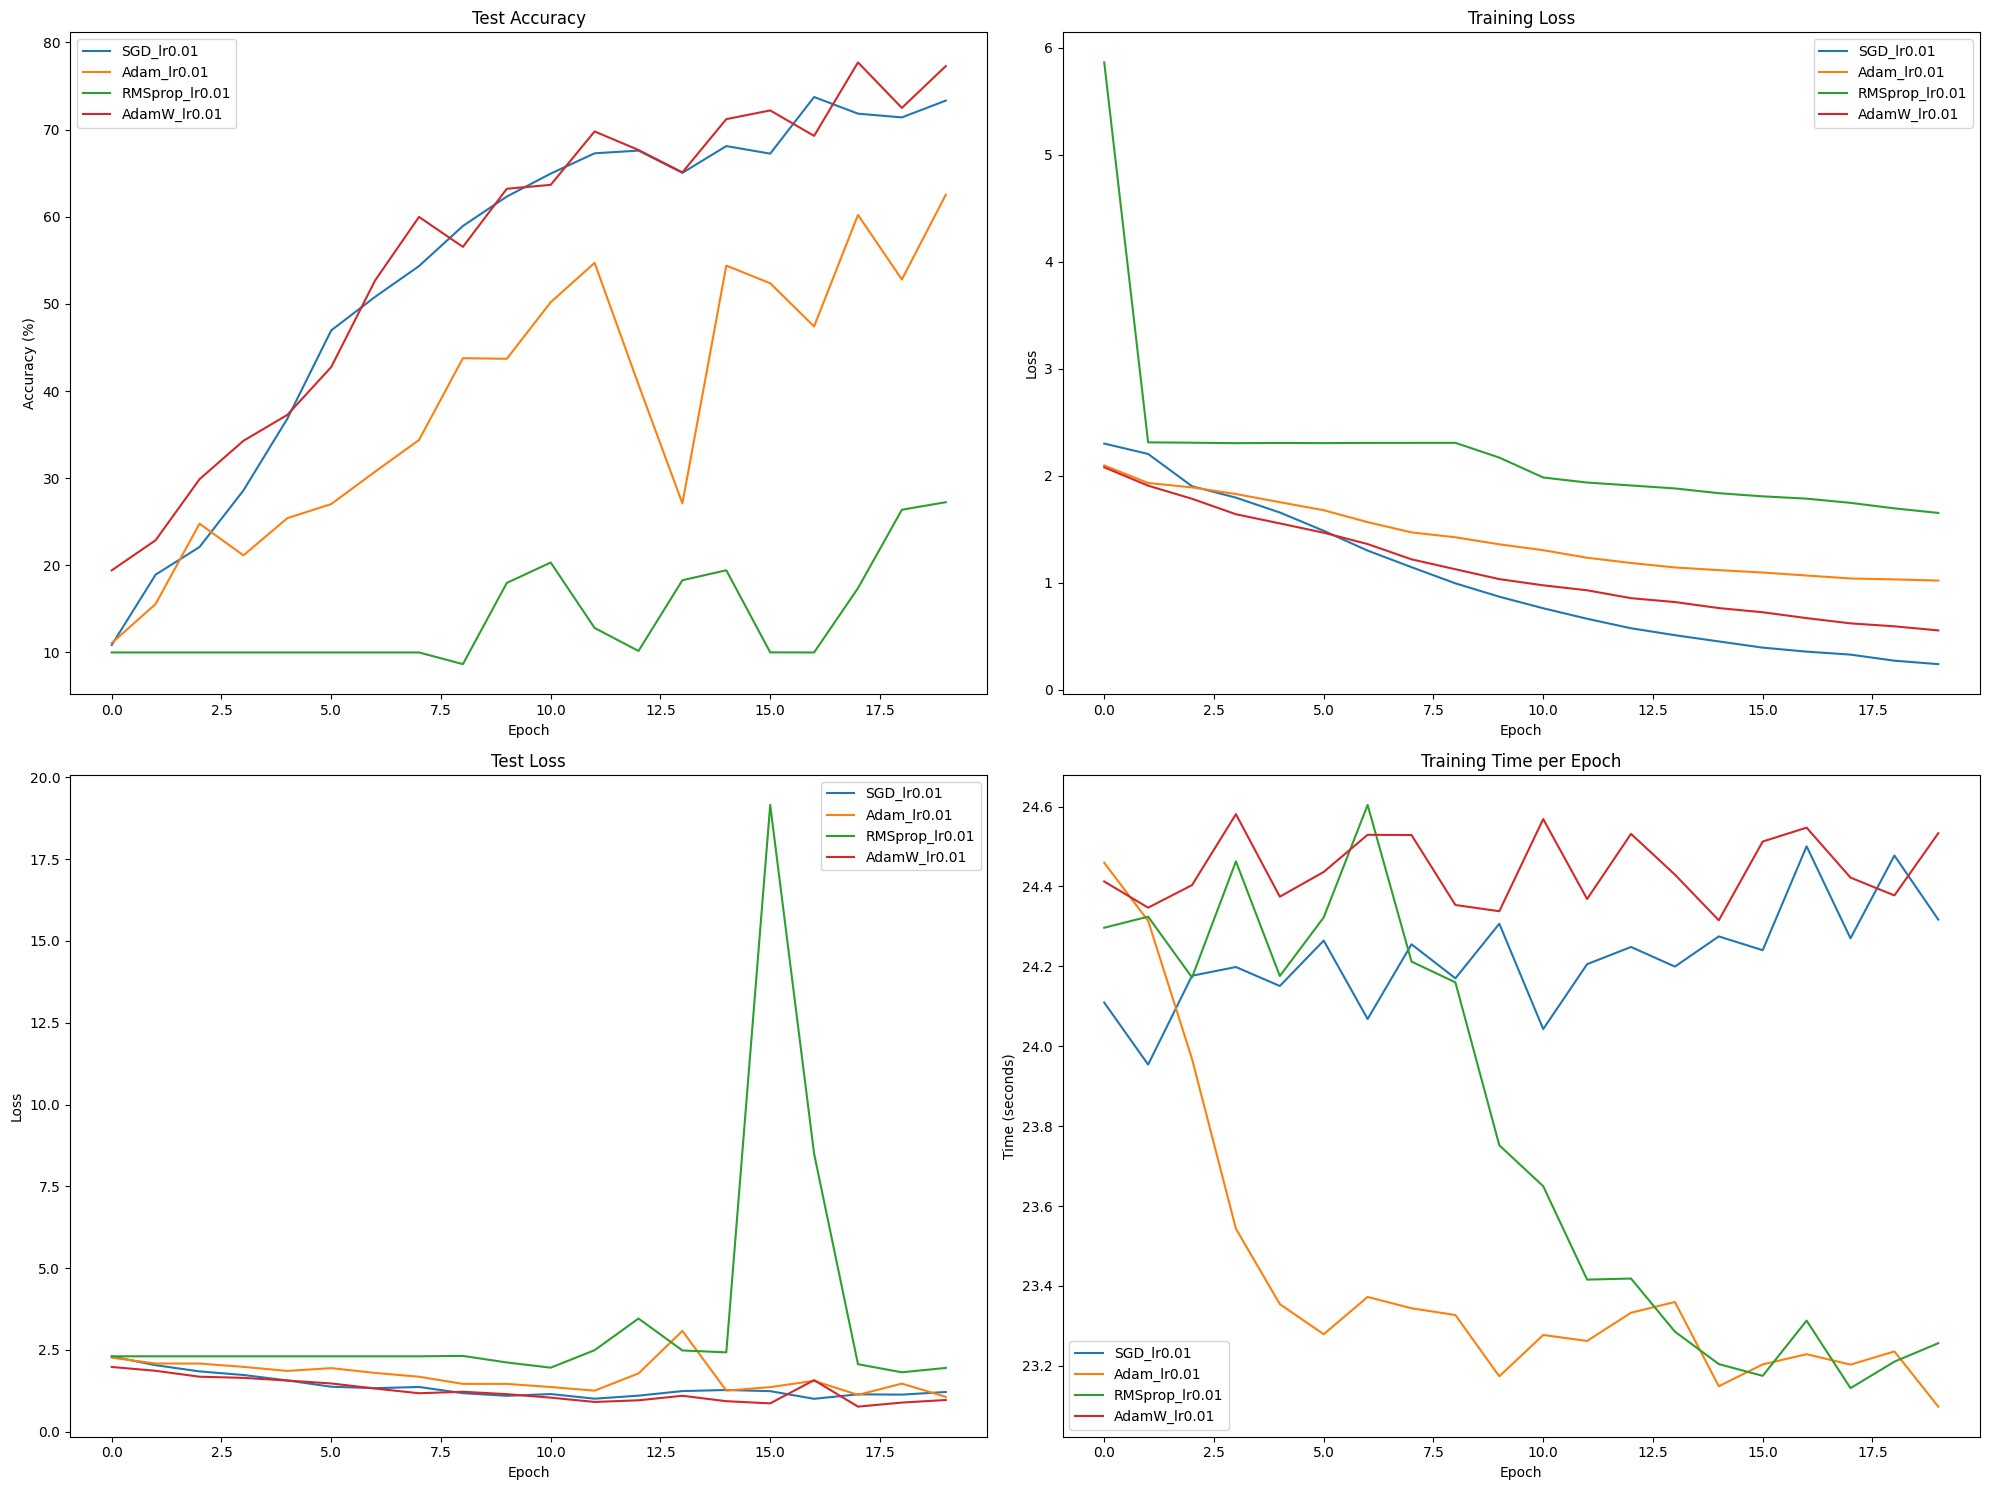


实验结果总结:
--------------------------------------------------------------------------------
实验配置                           最终准确率           总训练时间           每轮平均时间         
--------------------------------------------------------------------------------
SGD_lr0.01                     73.33          % 484.43         秒 24.22          秒
Adam_lr0.01                    62.53          % 468.49         秒 23.42          秒
RMSprop_lr0.01                 27.24          % 475.56         秒 23.78          秒
AdamW_lr0.01                   77.29          % 488.91         秒 24.45          秒
--------------------------------------------------------------------------------


In [6]:

# 可视化不同优化器和学习率的性能比较
plt.figure(figsize=(20, 15))

# 显示测试准确率
plt.subplot(2, 2, 1)
for exp_name in results:
    plt.plot(results[exp_name]['test_accs'], label=exp_name)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# 显示训练损失
plt.subplot(2, 2, 2)
for exp_name in results:
    plt.plot(results[exp_name]['train_losses'], label=exp_name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 显示测试损失
plt.subplot(2, 2, 3)
for exp_name in results:
    plt.plot(results[exp_name]['test_losses'], label=exp_name)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 显示每轮训练时间
plt.subplot(2, 2, 4)
for exp_name in results:
    plt.plot(results[exp_name]['times'], label=exp_name)
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.savefig('vgg13_optimizer_lr_comparison.png')
plt.show()

# 显示实验结果总结
print("\n实验结果总结:")
print("-" * 80)
print(f"{'实验配置':<30} {'最终准确率':<15} {'总训练时间':<15} {'每轮平均时间':<15}")
print("-" * 80)

for exp_name in results:
    final_acc = results[exp_name]['final_accuracy']
    total_time = results[exp_name]['total_time']
    avg_time = total_time / epoch_count
    
    print(f"{exp_name:<30} {final_acc:<15.2f}% {total_time:<15.2f}秒 {avg_time:<15.2f}秒")

print("-" * 80)

